# ROMMA Scraping again

Almost everyone knows that you can get time series by scraping pages.


https://www.infoclimat.fr/climatologie/normales-records/1981-2010/grenoble-lvd/valeurs/38538002.html

http://romma.fr/station_24.php?id=4&tempe=1

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import re
import time
import requests
import html


In [2]:
pp = re.compile('station_24\.php\?id=(\d+)"><b>(.*?),')
user_agent = {'User-agent': 'Mozilla/5.0'}

url = 'http://romma.fr/frame_station24.php'

r = requests.get('http://romma.fr', 
                 headers=user_agent)

stations = pp.findall(r.text)

In [3]:
code, name = zip(*stations)

In [109]:
#stations[:]

In [4]:
print(' '.join( [html.unescape(x) for x in name]) )

  BREGNIER-CORDON   VIRIAT   PONT-D'AIN   ST-ÉTIENNE-DU-BOIS   BOURG-EN-BRESSE   AMBÉRIEU-EN-BUGEY   SEYSSEL   BRIORD   LEAZ   LHOPITAL   INNIMOND   LELEX   LA VATTAY   SORGIA   MONTOISEY   SISTERON   DIGNE-LES-BAINS   ANNOT   CHAMPTERCIER   LA JAVIE   PRADS-HT-BLEONE   SELONNET   LE VERNET   SEYNE - LE GRAND PUY   SEYNE - LE FAUT   CHABANON   ST-PAUL-SUR-UBAYE   HAUT-CHABANON   GAP   LA BEAUME   EYGLIERS   LA FREISSINOUSE   ST-LEGER-LES-MELEZES   ORCIÈRES-CHAUFFAREL   ORCIÈRES-LES TOURRENGS   LES ORRES   PUY-SAINT-PIERRE   ORCIÈRES   RISTOLAS   SAINT-VÉRAN   COL DU LAUTARET   REFUGE CHAMOISSIERE   PLATEAU DE BURE   GILETTE   NICE   VENCE   TOURRETTE-LEVENS   CLANS   ST-VALLIER-DE-THIEY   CIPIÈRES   ILONSE   THORRENC   GRAVESON   MONTELIMAR   BOURG-LES-VALENCE   GRANGES-LES-BEAUMONT   AOUSTE-SUR-SYE   MONTBRISON-SUR-LEZ   CREST   ST-SORLIN-EN-VALLOIRE   DIE   LE PÈGUE   PEYRUS   RECOUBEAU   ST-JULIEN-EN-QUINT   TESSIÈRRES   ST-AGNAN-EN-VERCORS   VALOUSE   POMMEROL   BOULC   COMBE DE L'

## Extracting the data arrays

The good stuff is hiden in a frame but is easily accesible

In [158]:
def html2arrays(txt):
    def val2float(x):
        if x == '':
            return float('nan')
        return float(x)

    #I was dumping this from chrome and it  imposes fixed line widths
    #txt = re.sub('=\n','',txt)

    #json style null->nan
    #because we are going to cast string to float later
    txt = re.sub('null', 'nan', txt)

    pp = re.compile( 'var ([\w|\s]*?)array=.*?\[(.*?)\]', re.DOTALL)
    mm = pp.findall(txt)

    data = dict(mm)
    data.keys()

    fields = ['time', 'temp', 'pluie', 'intenspluie', 
              'pression', 'hum', 'rad','rafale','vent','ventdir']
    arrays = {}
    for key in fields:
       
        try:
            arrays[key] = np.array( [ val2float(x) for x in data[key].split(',')])
        except:
            print(key)
            
        #continue
        
        #this fixes holes in the time series
        if key == 'time':
            index = (arrays[key] - arrays[key][0])/600000 
            index = index.astype(np.int32)
            index[index > 4464] = 4463 # just to be safe
        else:
            fix = np.zeros(4464)
            fix[index] = arrays[key]
            arrays[key] = fix
            
    return arrays
        
def get_station(ref_num=6):       
    url = 'http://romma.fr/frame_station24.php' # why is this hard coded ?
    user_agent = {'User-agent': 'Mozilla/5.0'}
    
    r = requests.post(url, 
                     headers=user_agent,
                     params={"id_station":ref_num, "tempe":1})
    
    return r.text

smh = 4
voiron = 109
orange = 54
tt = get_station(ref_num=6)
meteo = html2arrays(tt)
for x,y in meteo.items():
    print(x, len(y))

time 4464
temp 4464
pluie 4464
intenspluie 4464
pression 4464
hum 4464
rad 4464
rafale 4464
vent 4464
ventdir 4464


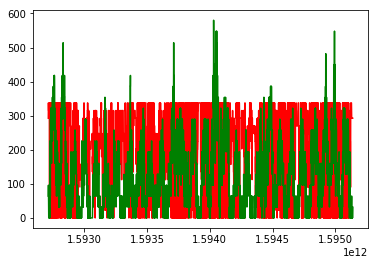

In [80]:
ww = 28*24*6
plt.plot(meteo['time'][-ww:], meteo['ventdir'][-ww:],'r')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:]*20,'g')

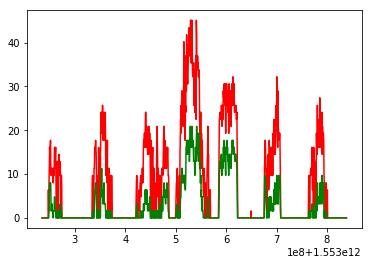

In [5]:
ww = 7*24*6
plt.plot(meteo['time'][-ww:], meteo['rafale'][-ww:],'r')
#plt.plot(tt[-ww:],np.diff(temp,n=1)[-ww:],'b')
plt.plot( meteo['time'][-ww:], meteo['vent'][-ww:],'g')

    

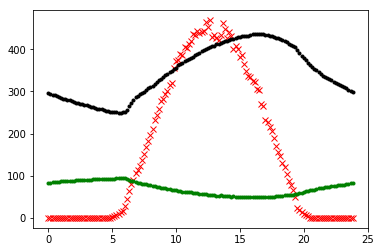

In [172]:
def hour(x):
    tt = time.localtime(x/1000)
    return tt.tm_hour + tt.tm_min/60
    
day = 24*6

def tot(key='rad'):
    day = 24*6
    tot = np.zeros((day), dtype=np.float32)
    for k in range(31):
        tot += np.roll(meteo[key], k*day)[:day]
    return tot

    
# this is a bit risky it assumes there isn't a hole in the data
times = np.array([hour(x) for x in meteo['time'][:day]])
times = np.roll(times, 6)


#plt.plot( times, tot(key='vent'),'b.')
plt.plot( times ,tot(key='rad')/50,'rx')
plt.plot( times ,tot(key='temp')/2,'k.')
plt.plot( times ,tot(key='hum')/28,'g.')

In [163]:
times = np.arange(144)/6


# There must be a better way

the function tot() kind of sucks  
- it's not very **numpy**.

In [44]:
np.arange(12).reshape(3,4)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

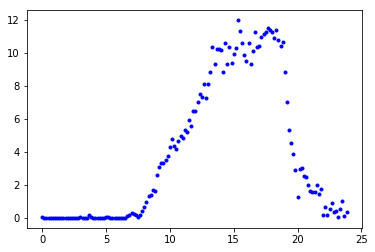

In [168]:
npts = meteo['vent'].shape[0]
ndays = npts//24//6
mm = meteo['rafale'].reshape(ndays, 24*6)/ndays
plt.plot(times, np.sum(mm, axis=0), 'b.')

## Let's show them all in a multiplot

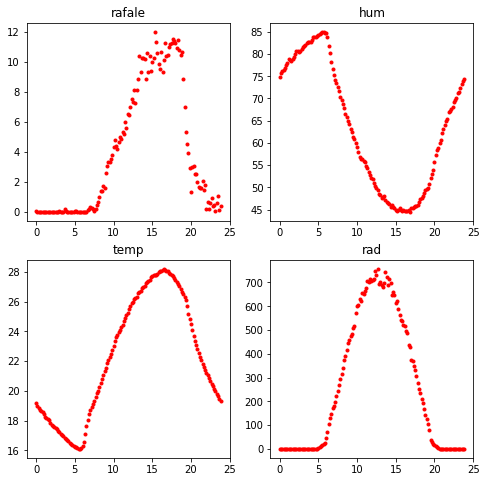

In [169]:
fig, axs = plt.subplots(2,2)
#[axi.set_axis_off() for axi in axs.ravel()]
fig.set_size_inches(8,8)

npts = meteo['vent'].shape[0]
ndays = npts//24//6

for k, tag in enumerate(['rafale','temp','hum','rad']):
    mm = meteo[tag].reshape(ndays, 24*6)/ndays
    mm[mm > 1000] = 0 #kill the outlier
    axs[k % 2 , k // 2].plot(times, np.sum(mm, axis=0),'r.')
    axs[k % 2 , k // 2].set_title(tag)
    

## Finally calculate the time of max temperature

I checked this by hand it seems to be pretty accurate

In [171]:
numdays = 21
ts = [i for i in range(-1,-1 - numdays*24*6, -24*6)]

day_intervals = [list(zip(meteo['temp'],meteo['time']))[i:j] for i,j in  zip(ts[1:],ts)]
mx = [max(day) for day in day_intervals if day]
x,y = zip(*mx)
[time.ctime(t/1000.) for t in y]

['Sat Jul 18 18:20:00 2020',
 'Fri Jul 17 15:10:00 2020',
 'Thu Jul 16 19:00:00 2020',
 'Wed Jul 15 13:10:00 2020',
 'Tue Jul 14 17:10:00 2020',
 'Mon Jul 13 16:20:00 2020',
 'Sun Jul 12 17:30:00 2020',
 'Sat Jul 11 17:20:00 2020',
 'Fri Jul 10 17:00:00 2020',
 'Thu Jul  9 17:20:00 2020',
 'Wed Jul  8 17:20:00 2020',
 'Tue Jul  7 18:30:00 2020',
 'Mon Jul  6 16:50:00 2020',
 'Sun Jul  5 18:30:00 2020',
 'Sat Jul  4 18:30:00 2020',
 'Fri Jul  3 17:10:00 2020',
 'Thu Jul  2 17:20:00 2020',
 'Wed Jul  1 15:50:00 2020',
 'Tue Jun 30 18:40:00 2020',
 'Mon Jun 29 14:20:00 2020']

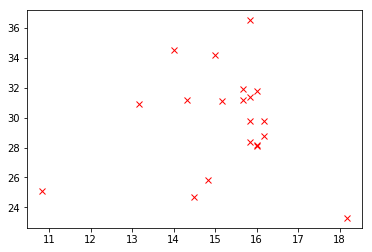

In [76]:
XS, YS = zip(*mx)
YS = [(int(y)//1000 % (24*3600)) /3600 for y in YS]
plt.plot(YS,XS, 'rx')

In [75]:
night = meteo['time'][meteo['rad'] == 0]
xx = stuff[:-1][np.diff(night)  > 600000]

NameError: name 'stuff' is not defined

In [15]:
trans = [int(y)//1000 % (24*3600) /3600 for y in xx]
trans = [ min(x,8) for x in trans ]

plt.plot(range(len(trans)),trans,'rx')

NameError: name 'xx' is not defined

In [105]:
xx = '[6.4,3.2,3.2,6.4,6.4,9.7,12.9,11.3,11.3,8.0,8.0,14.5,11.3,12.9,14.5,16.1,8.0,11.3,12.9,14.5,12.9,9.7,12.9,19.3,19.3,16.1,9.7,9.7,8.0,9.7,16.1,11.3,14.5,17.7,20.9,14.5,14.5,12.9,14.5,14.5,8.0,22.5,20.9,16.1,22.5,25.7,20.9,20.9,17.7,17.7,19.3,17.7,14.5,14.5,12.9,14.5,12.9,6.4,11.3,11.3,8.0,3.2,6.4,8.0,9.7,8.0,11.3,16.1,19.3,22.5,17.7,14.5,16.1,9.7,4.8,9.7,8.0,3.2,14.5,12.9,17.7,9.7,22.5,33.8,27.4,25.7,20.9,17.7,20.9,16.1,25.7,24.1,24.1,25.7,29.0,25.7,24.1,24.1,9.7,9.7,14.5,19.3,20.9,14.5,8.0,4.8,3.2,6.4,6.4,9.7,8.0,6.4,4.8,3.2,1.6,6.4,6.4,3.2,3.2,4.8,4.8,0.0,0.0,0.0,0.0,0.0,4.8,4.8,0.0,3.2,3.2,0.0,3.2,3.2,3.2,1.6,6.4,6.4,4.8,11.3,8.0,4.8,4.8,4.8,4.8,0.0,4.8,4.8,6.4,6.4,6.4,6.4,11.3,9.7,11.3,8.0,8.0,3.2,6.4,11.3,12.9,8.0,14.5,20.9,19.3,25.7,22.5,20.9,14.5,9.7,16.1,20.9,17.7,25.7,25.7,22.5,17.7,22.5,25.7,27.4,22.5,22.5,19.3,27.4,25.7,22.5,20.9,24.1,19.3,25.7,25.7,24.1,29.0,20.9,25.7,19.3,20.9,20.9,14.5,20.9,27.4,24.1,25.7,25.7,24.1,22.5,19.3,20.9,20.9,16.1,17.7,14.5,16.1,16.1,12.9,14.5,9.7,12.9,14.5,12.9,14.5,14.5,12.9,14.5,9.7,6.4,4.8,8.0,9.7,6.4,3.2,3.2,4.8,9.7,12.9,4.8,4.8,4.8,1.6,0.0,0.0,4.8,3.2,6.4,4.8,8.0,9.7,14.5,8.0,6.4,6.4,3.2,4.8,3.2,4.8,1.6,0.0,0.0,3.2,1.6,0.0,0.0,3.2,4.8,0.0,0.0,4.8,6.4,6.4,0.0,0.0,0.0,3.2,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2,3.2,1.6,0.0,6.4,3.2,4.8,8.0,11.3,11.3,11.3,8.0,9.7,8.0,8.0,9.7,8.0,4.8,9.7,19.3,19.3,12.9,19.3,20.9,17.7,19.3,22.5,24.1,27.4,29.0,27.4,30.6,25.7,29.0,32.2,27.4,29.0,25.7,30.6,20.9,25.7,24.1,19.3,29.0,22.5,27.4,24.1,24.1,27.4,22.5,24.1,24.1,25.7,30.6,29.0,29.0,30.6,20.9,22.5,17.7,24.1,24.1,20.9,25.7,22.5,25.7,24.1,22.5,20.9,20.9,25.7,19.3,17.7,22.5,20.9,16.1,24.1,19.3,14.5,14.5,9.7,17.7,24.1,12.9,14.5,16.1,14.5,12.9,14.5,20.9,12.9,11.3,9.7,8.0,4.8,4.8,1.6,6.4,6.4,6.4,9.7,9.7,9.7,12.9,14.5,14.5,8.0,9.7,6.4,6.4,9.7,4.8,4.8,4.8,4.8,3.2,3.2,3.2,3.2,4.8,3.2,0.0,4.8,3.2,1.6,8.0,8.0,4.8,4.8,4.8,4.8,3.2,4.8,6.4,6.4,4.8,4.8,3.2,4.8,6.4,8.0,9.7,6.4,4.8,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.8,3.2,4.8,6.4,4.8,4.8,9.7,9.7,19.3,20.9,22.5,14.5,22.5,19.3,14.5,17.7,24.1,27.4,20.9,25.7,29.0,33.8,29.0,27.4,32.2,24.1,30.6,25.7,29.0,27.4,24.1,29.0,27.4,25.7,22.5,30.6,27.4,29.0,25.7,30.6,32.2,20.9,32.2,25.7,27.4,27.4,27.4,29.0,27.4,25.7,29.0,29.0,22.5,30.6,30.6,27.4,33.8,25.7,25.7,25.7,29.0,29.0,33.8,25.7,29.0,29.0,32.2,30.6,35.4,30.6,27.4,27.4,30.6,22.5,29.0,25.7,17.7,24.1,22.5,22.5,24.1,29.0,27.4,19.3,24.1,25.7,19.3,19.3,17.7,24.1,11.3,14.5,14.5,11.3,11.3,14.5,9.7,17.7,14.5,17.7,19.3,14.5,20.9,22.5,22.5,20.9,19.3,12.9,9.7,24.1,12.9,14.5,9.7,16.1,17.7,14.5,12.9,16.1,12.9,12.9,14.5,16.1,14.5,11.3,8.0,6.4,4.8,3.2,3.2,4.8,4.8,8.0,6.4,8.0,6.4,8.0,6.4,3.2,9.7,8.0,9.7,9.7,17.7,11.3,14.5,16.1,17.7,11.3,12.9,12.9,9.7,12.9,16.1,20.9,16.1,12.9,24.1,25.7,17.7,24.1,25.7,27.4,29.0,24.1,30.6,25.7,32.2,30.6,33.8,35.4,33.8,30.6,30.6,37.0,30.6,37.0,33.8,35.4,30.6,37.0,35.4,40.2,38.6,33.8,43.5,33.8,32.2,37.0,29.0,35.4,41.8,30.6,30.6,32.2,29.0,27.4,30.6,30.6,25.7,30.6,35.4,33.8,33.8,32.2,35.4,33.8,20.9,40.2,33.8,30.6,32.2,22.5,32.2,25.7,29.0,22.5,24.1,22.5,27.4,14.5,17.7,16.1,17.7,14.5,16.1,9.7,14.5,14.5,14.5,9.7,6.4,9.7,12.9,12.9,16.1,12.9,12.9,4.8,6.4,6.4,6.4,1.6,4.8,3.2,3.2,0.0,3.2,1.6,1.6,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4,6.4,8.0,8.0,6.4,8.0,8.0,6.4,8.0,8.0,3.2,4.8,4.8,3.2,3.2,3.2,3.2,4.8,6.4,1.6,3.2,4.8,4.8,3.2,11.3,16.1,14.5,16.1,19.3,17.7,14.5,12.9,16.1,14.5,11.3,6.4,9.7,9.7,11.3,4.8,9.7,12.9,8.0,9.7,8.0,6.4,6.4,9.7,9.7,8.0,6.4,6.4,8.0,12.9,9.7,12.9,17.7,16.1,16.1,14.5,16.1,14.5,17.7,14.5,14.5,16.1,14.5,17.7,19.3,17.7,14.5,20.9,17.7,14.5,17.7,14.5,19.3,17.7,17.7,19.3,19.3,19.3,20.9,17.7,20.9,17.7,20.9,20.9,20.9,20.9,19.3,16.1,20.9,17.7,19.3,17.7,17.7,17.7,12.9,14.5,14.5,12.9,9.7,8.0,12.9,8.0,4.8,1.6,3.2,4.8,4.8,4.8,4.8,8.0,8.0,6.4,4.8,3.2,1.6,3.2,6.4,6.4,4.8,6.4,4.8,6.4,4.8,4.8,4.8,3.2,4.8,6.4,4.8,4.8,4.8,0.0,1.6,6.4,4.8,0.0,4.8,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.8,8.0,1.6,1.6,1.6,1.6,4.8,3.2,3.2,3.2,3.2,9.7,17.7,22.5,16.1,16.1,11.3,8.0,6.4,11.3,14.5,14.5,9.7,12.9,11.3,11.3,12.9,9.7,4.8,11.3,11.3,6.4,4.8,12.9,11.3,16.1,12.9,9.7,12.9,11.3,16.1,17.7,14.5,22.5,14.5,14.5,17.7,24.1,19.3,22.5,17.7,19.3,19.3,19.3,22.5,16.1,20.9,17.7,17.7,19.3,19.3,27.4,19.3,22.5,14.5,22.5,20.9,16.1,24.1,16.1,16.1,14.5,14.5,12.9,14.5,14.5,12.9,9.7,12.9,9.7,8.0,8.0,8.0,8.0,4.8,4.8,6.4,6.4,4.8,6.4,8.0,4.8,4.8,4.8,3.2,3.2,4.8,1.6,3.2,4.8,6.4,11.3,6.4,4.8,3.2,3.2,4.8,3.2,0.0,8.0,3.2,3.2,4.8,3.2,3.2,3.2,3.2,3.2,4.8,4.8,0.0,3.2,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4,9.7,9.7,9.7,8.0,8.0,6.4,8.0,6.4,4.8,9.7,12.9,9.7,11.3,12.9,12.9,9.7,12.9,8.0,9.7,12.9,9.7,16.1,12.9,16.1,12.9,11.3,22.5,16.1,17.7,20.9,14.5,14.5,14.5,12.9,14.5,14.5,14.5,11.3,17.7,11.3,12.9,11.3,12.9,14.5,14.5,14.5,16.1,12.9,16.1,16.1,16.1,12.9,24.1,17.7,16.1,12.9,16.1,16.1,16.1,14.5,14.5,14.5,12.9,12.9,14.5,12.9,12.9,6.4,11.3,11.3,11.3,11.3,8.0,9.7,4.8,6.4,11.3,14.5,9.7,9.7,11.3,12.9,12.9,11.3,12.9,11.3,8.0,4.8,6.4,6.4,6.4,4.8,4.8,3.2,3.2,0.0,4.8,3.2,1.6,3.2,6.4,1.6,4.8,3.2,3.2,0.0,0.0,4.8,3.2,4.8,3.2,3.2,1.6,3.2,4.8,3.2,0.0,0.0,4.8,3.2,4.8,3.2,6.4,1.6,0.0,0.0,0.0,0.0,0.0,3.2,3.2,3.2,4.8,1.6,4.8,4.8,1.6,4.8,6.4,8.0,12.9,9.7,11.3,12.9,14.5,4.8,6.4,3.2,4.8,11.3,8.0,6.4,6.4,8.0,11.3,11.3,14.5,16.1,8.0,19.3,20.9,22.5,22.5,16.1,25.7,25.7,20.9,17.7,20.9,17.7,24.1,25.7,25.7,20.9,19.3,20.9,12.9,14.5,9.7,14.5,6.4,14.5,16.1,14.5,11.3,9.7,6.4,4.8,6.4,6.4,6.4,8.0,4.8,9.7,9.7,12.9,14.5,12.9,14.5,8.0,8.0,4.8,9.7,4.8,6.4,3.2,4.8,4.8,6.4,12.9,12.9,4.8,4.8,6.4,6.4,4.8,4.8,8.0,6.4,4.8,4.8,3.2,9.7,4.8,6.4,6.4,12.9,4.8,4.8,4.8,6.4,4.8,6.4,3.2,4.8,6.4,1.6,1.6,0.0,3.2,0.0,4.8,8.0,6.4,3.2,4.8,6.4,6.4,4.8,9.7,4.8,4.8,3.2,6.4,6.4,11.3,6.4,3.2,4.8,1.6,6.4,3.2,0.0,6.4,3.2,3.2,11.3,3.2,0.0,4.8,1.6,4.8,8.0,4.8,3.2,8.0,6.4,12.9,11.3,8.0,14.5,14.5,6.4,22.5,16.1,11.3,11.3,12.9,11.3,6.4,11.3,14.5,16.1,12.9,11.3,11.3,9.7,12.9,14.5,11.3,9.7,12.9,9.7,14.5,12.9,8.0,9.7,8.0,8.0,11.3,6.4,11.3,12.9,16.1,11.3,11.3,9.7,12.9,11.3,12.9,11.3,11.3,16.1,16.1,8.0,14.5,12.9,19.3,14.5,19.3,16.1,16.1,12.9,11.3,14.5,14.5,14.5,22.5,20.9,20.9,17.7,17.7,19.3,20.9,19.3,22.5,16.1,14.5,14.5,14.5,12.9,16.1,11.3,14.5,11.3,16.1,14.5,6.4,9.7,6.4,6.4,6.4,4.8,6.4,6.4,4.8,3.2,4.8,6.4,4.8,3.2,1.6,4.8,8.0,1.6,6.4,3.2,4.8,3.2,4.8,4.8,4.8,3.2,3.2,3.2,1.6,3.2,3.2,4.8,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.4,6.4,4.8,1.6,6.4,3.2,4.8,0.0,3.2,3.2,1.6,3.2,3.2,8.0,11.3,9.7,6.4,3.2,4.8,1.6,1.6,3.2,1.6,3.2,1.6,3.2,6.4,4.8,4.8,3.2,9.7,9.7,8.0,6.4,4.8,9.7,12.9,11.3,11.3,6.4,6.4,9.7,9.7,6.4,6.4,14.5,11.3,11.3,16.1,12.9,11.3,11.3,11.3,12.9,16.1,16.1,17.7,11.3,12.9,8.0,9.7,6.4,11.3,16.1,11.3,12.9,12.9,12.9,14.5,14.5,14.5,17.7,16.1,14.5,16.1,14.5,8.0,14.5,12.9,12.9,6.4,8.0,4.8,11.3,12.9,11.3,9.7,16.1,14.5,11.3,11.3,11.3,9.7,8.0,8.0,6.4,27.4,35.4,32.2,32.2,33.8,17.7,19.3,27.4,16.1,17.7,16.1,9.7,12.9,9.7,9.7,9.7,9.7,19.3,19.3,14.5,19.3,17.7,19.3,16.1,3.2,12.9,16.1,16.1,14.5,9.7,8.0,8.0,4.8,8.0,6.4,4.8,12.9,9.7,4.8,0.0,4.8,6.4,6.4,6.4,6.4,11.3,12.9,6.4,8.0,9.7,6.4,6.4,6.4,8.0,4.8,1.6,0.0,3.2,6.4,4.8,3.2,4.8,4.8,4.8,4.8,3.2,4.8,8.0,6.4,4.8,3.2,4.8,3.2,4.8,3.2,0.0,0.0,0.0,6.4,8.0,6.4,4.8,6.4,6.4,8.0,6.4,8.0,8.0,6.4,6.4,8.0,11.3,11.3,14.5,12.9,9.7,9.7,9.7,16.1,16.1,12.9,9.7,9.7,24.1,12.9,14.5,17.7,16.1,19.3,16.1,17.7,20.9,19.3,16.1,14.5,8.0,9.7,19.3,14.5,16.1,17.7,12.9,16.1,12.9,16.1,14.5,14.5,16.1,14.5,14.5,16.1,16.1,17.7,17.7,20.9,17.7,17.7,20.9,17.7,16.1,16.1,14.5,14.5,14.5,17.7,19.3,17.7,17.7,19.3,16.1,9.7,12.9,17.7,16.1,14.5,14.5,12.9,6.4,6.4,9.7,12.9,6.4,8.0,12.9,12.9,14.5,3.2,6.4,8.0,12.9,8.0,25.7,27.4,27.4,20.9,20.9,16.1,17.7,20.9,24.1,22.5,22.5,20.9,17.7,12.9,16.1,16.1,14.5,12.9,6.4,6.4,4.8,4.8,4.8,4.8,6.4,6.4,6.4,3.2,3.2,4.8,8.0,4.8,4.8,4.8,6.4,4.8,4.8,0.0,0.0,3.2,6.4,1.6,4.8,4.8,6.4,4.8,6.4,6.4,11.3,11.3,9.7,9.7,8.0,11.3,12.9,12.9,12.9,6.4,11.3,6.4,16.1,14.5,12.9,12.9,8.0,19.3,17.7,16.1,17.7,12.9,12.9,9.7,9.7,16.1,16.1,24.1,16.1,17.7,16.1,17.7,9.7,16.1,20.9,16.1,12.9,14.5,19.3,16.1,17.7,12.9,14.5,14.5,17.7,16.1,17.7,14.5,11.3,19.3,16.1,14.5,14.5,11.3,12.9,8.0,11.3,12.9,16.1,16.1,17.7,16.1,17.7,19.3,16.1,16.1,14.5,12.9,14.5,12.9,9.7,6.4,9.7,9.7,9.7,9.7,12.9,9.7,6.4,6.4,14.5,9.7,6.4,4.8,4.8,1.6,4.8,4.8,4.8,8.0,6.4,8.0,4.8,4.8,6.4,6.4,4.8,4.8,3.2,3.2,3.2,3.2,4.8,0.0,6.4,3.2,8.0,11.3,6.4,3.2,4.8,4.8,4.8,3.2,4.8,4.8,8.0,8.0,14.5,11.3,9.7,11.3,9.7,11.3,9.7,6.4,8.0,8.0,3.2,6.4,4.8,3.2,4.8,3.2,3.2,1.6,3.2,1.6,4.8,6.4,9.7,11.3,8.0,8.0,6.4,3.2,9.7,11.3,9.7,9.7,4.8,4.8,4.8,11.3,8.0,11.3,4.8,6.4,6.4,11.3,12.9,11.3,11.3,6.4,4.8,6.4,9.7,12.9,19.3,14.5,14.5,16.1,16.1,17.7,12.9,16.1,17.7,25.7,17.7,17.7,14.5,11.3,11.3,14.5,14.5,16.1,17.7,12.9,17.7,11.3,16.1,19.3,17.7,25.7,19.3,17.7,12.9,11.3,17.7,17.7,16.1,14.5,14.5,14.5,11.3,16.1,22.5,24.1,24.1,20.9,17.7,22.5,20.9,11.3,8.0,6.4,4.8,3.2,4.8,8.0,11.3,9.7,20.9,16.1,14.5,17.7,9.7,12.9,12.9,14.5,9.7,6.4,6.4,6.4,1.6,4.8,6.4,3.2,6.4,1.6,4.8,8.0,6.4,3.2,4.8,6.4,4.8,4.8,1.6,4.8,8.0,8.0,4.8,0.0,6.4,1.6,9.7,8.0,9.7,8.0,1.6,8.0,9.7,8.0,3.2,1.6,8.0,4.8,3.2,4.8,4.8,3.2,3.2,4.8,3.2,1.6,0.0,3.2,6.4,0.0,0.0,4.8,3.2,3.2,6.4,11.3,9.7,11.3,12.9,9.7,8.0,4.8,4.8,3.2,4.8,6.4,9.7,9.7,9.7,8.0,6.4,6.4,8.0,9.7,11.3,16.1,11.3,14.5,12.9,17.7,16.1,16.1,17.7,14.5,16.1,14.5,14.5,16.1,12.9,14.5,12.9,6.4,11.3,11.3,14.5,20.9,22.5,24.1,25.7,30.6,27.4,25.7,25.7,22.5,25.7,25.7,20.9,24.1,24.1,19.3,20.9,24.1,24.1,20.9,24.1,24.1,27.4,29.0,29.0,32.2,29.0,33.8,29.0,24.1,27.4,40.2,46.7,33.8,38.6,40.2,37.0,38.6,33.8,24.1,19.3,19.3,14.5,19.3,20.9,16.1,16.1,14.5,14.5,14.5,9.7,6.4,11.3,19.3,17.7,17.7,14.5,16.1,19.3,22.5,17.7,14.5,22.5,17.7,20.9,20.9,22.5,22.5,19.3,24.1,17.7,14.5,16.1,17.7,20.9,20.9,24.1,25.7,24.1,27.4,25.7,25.7,24.1,29.0,22.5,24.1,25.7,24.1,22.5,16.1,14.5,9.7,8.0,8.0,9.7,14.5,9.7,9.7,14.5,16.1,16.1,16.1,14.5,14.5,19.3,12.9,20.9,16.1,17.7,17.7,20.9,19.3,17.7,19.3,14.5,19.3,19.3,24.1,17.7,24.1,25.7,20.9,27.4,27.4,22.5,16.1,17.7,19.3,16.1,9.7,14.5,25.7,20.9,22.5,19.3,24.1,14.5,17.7,16.1,19.3,17.7,27.4,30.6,25.7,27.4,17.7,20.9,29.0,24.1,19.3,17.7,22.5,25.7,22.5,20.9,19.3,17.7,19.3,20.9,19.3,17.7,22.5,20.9,22.5,19.3,16.1,17.7,17.7,19.3,17.7,9.7,11.3,9.7,12.9,12.9,4.8,8.0,12.9,9.7,12.9,20.9,14.5,16.1,9.7,14.5,19.3,24.1,14.5,16.1,14.5,19.3,17.7,16.1,14.5,17.7,16.1,16.1,16.1,4.8,6.4,6.4,6.4,3.2,4.8,9.7,9.7,8.0,8.0,8.0,12.9,14.5,12.9,9.7,12.9,12.9,12.9,6.4,9.7,12.9,9.7,8.0,4.8,12.9,14.5,14.5,16.1,20.9,14.5,12.9,12.9,4.8,4.8,6.4,6.4,8.0,8.0,6.4,6.4,3.2,6.4,4.8,4.8,4.8,4.8,4.8,3.2,4.8,8.0,8.0,8.0,9.7,8.0,8.0,9.7,11.3,8.0,6.4,11.3,11.3,14.5,12.9,6.4,8.0,9.7,17.7,19.3,16.1,14.5,20.9,20.9,22.5,16.1,24.1,20.9,25.7,20.9,22.5,16.1,22.5,17.7,16.1,17.7,16.1,16.1,20.9,14.5,17.7,17.7,22.5,19.3,22.5,22.5,22.5,24.1,16.1,22.5,24.1,22.5,20.9,20.9,24.1,25.7,25.7,22.5,22.5,22.5,19.3,25.7,19.3,22.5,22.5,24.1,22.5,22.5,20.9,22.5,20.9,19.3,17.7,19.3,22.5,19.3,14.5,16.1,11.3,9.7,16.1,17.7,14.5,12.9,9.7,6.4,8.0,9.7,9.7,14.5,12.9,14.5,12.9,14.5,8.0,6.4,6.4,3.2,6.4,4.8,8.0,6.4,6.4,3.2,1.6,0.0,4.8,3.2,3.2,4.8,1.6,4.8,6.4,4.8,3.2,1.6,1.6,4.8,4.8,3.2,3.2,1.6,0.0,0.0,3.2,3.2,0.0,1.6,3.2,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.8,1.6,0.0,0.0,0.0,4.8,8.0,4.8,4.8,4.8,3.2,4.8,4.8,6.4,9.7,6.4,8.0,8.0,12.9,16.1,16.1,9.7,16.1,19.3,19.3,16.1,17.7,19.3,17.7,19.3,16.1,19.3,19.3,24.1,19.3,16.1,19.3,19.3,19.3,19.3,19.3,25.7,20.9,20.9,19.3,19.3,16.1,22.5,12.9,19.3,24.1,19.3,20.9,22.5,25.7,27.4,24.1,17.7,22.5,22.5,22.5,29.0,24.1,27.4,27.4,20.9,24.1,19.3,22.5,20.9,22.5,25.7,25.7,25.7,17.7,19.3,24.1,22.5,19.3,20.9,19.3,19.3,17.7,12.9,16.1,14.5,12.9,11.3,14.5,9.7,6.4,6.4,9.7,9.7,9.7,16.1,12.9,9.7,8.0,9.7,8.0,6.4,8.0,14.5,24.1,22.5,19.3,4.8,6.4,6.4,9.7,9.7,9.7,9.7,9.7,9.7,6.4,9.7,4.8,16.1,6.4,6.4,6.4,3.2,1.6,4.8,6.4,3.2,3.2,3.2,3.2,4.8,4.8,3.2,4.8,4.8,4.8,11.3,8.0,4.8,4.8,8.0,9.7,17.7,19.3,12.9,19.3,14.5,16.1,12.9,22.5,24.1,24.1,22.5,22.5,20.9,19.3,22.5,22.5,20.9,20.9,16.1,9.7,19.3,22.5,22.5,19.3,14.5,27.4,16.1,16.1,29.0,32.2,32.2,35.4,27.4,30.6,37.0,49.9,41.8,37.0,38.6,33.8,35.4,40.2,35.4,27.4,29.0,35.4,37.0,32.2,38.6,37.0,25.7,25.7,22.5,27.4,22.5,30.6,25.7,22.5,22.5,25.7,29.0,27.4,41.8,33.8,35.4,37.0,30.6,35.4,48.3,41.8,40.2,41.8,43.5,43.5,35.4,43.5,40.2,33.8,41.8,37.0,33.8,27.4,30.6,29.0,19.3,37.0,29.0,24.1,24.1,27.4,22.5,25.7,27.4,27.4,27.4,25.7,33.8,27.4,22.5,25.7,27.4,24.1,24.1,17.7,17.7,12.9,9.7,16.1,16.1,6.4,8.0,6.4,8.0,6.4,3.2,3.2,4.8,4.8,3.2,4.8,6.4,9.7,6.4,6.4,9.7,14.5,20.9,27.4,25.7,29.0,25.7,32.2,22.5,33.8,24.1,25.7,22.5,20.9,16.1,22.5,16.1,9.7,17.7,24.1,17.7,16.1,16.1,12.9,9.7,9.7,16.1,19.3,20.9,17.7,20.9,20.9,17.7,16.1,20.9,14.5,22.5,14.5,17.7,22.5,24.1,24.1,22.5,20.9,30.6,25.7,20.9,22.5,17.7,25.7,32.2,37.0,29.0,33.8,27.4,29.0,27.4,27.4,25.7,20.9,24.1,27.4,20.9,22.5,29.0,29.0,27.4,30.6,32.2,29.0,24.1,24.1,25.7,29.0,22.5,25.7,22.5,25.7,19.3,27.4,27.4,25.7,22.5,25.7,24.1,27.4,27.4,30.6,20.9,27.4,20.9,19.3,29.0,25.7,20.9,22.5,27.4,27.4,25.7,25.7,22.5,27.4,27.4,25.7,27.4,17.7,17.7,19.3,20.9,25.7,24.1,19.3,22.5,16.1,9.7,16.1,12.9,11.3,8.0,6.4,1.6,4.8,4.8,6.4,4.8,4.8,9.7,3.2,1.6,0.0,4.8,8.0,3.2,1.6,1.6,1.6,0.0,3.2,1.6,3.2,3.2,1.6,3.2,3.2,4.8,4.8,4.8,4.8,4.8,6.4,3.2,1.6,0.0,0.0,0.0,4.8,4.8,1.6,4.8,3.2,4.8,6.4,8.0,4.8,4.8,4.8,4.8,3.2,3.2,1.6,3.2,4.8,4.8,4.8,6.4,4.8,3.2,3.2,4.8,4.8,6.4,4.8,4.8,9.7,8.0,8.0,8.0,8.0,11.3,14.5,12.9,12.9,9.7,9.7,16.1,4.8,14.5,17.7,16.1,14.5,16.1,14.5,16.1,16.1,17.7,17.7,24.1,16.1,17.7,25.7,20.9,22.5,22.5,20.9,17.7,20.9,19.3,30.6,14.5,9.7,9.7,20.9,17.7,20.9,17.7,16.1,20.9,16.1,19.3,16.1,19.3,19.3,14.5,12.9,16.1,14.5,16.1,17.7,14.5,17.7,17.7,16.1,16.1,12.9,16.1,12.9,14.5,14.5,14.5,9.7,14.5,14.5,12.9,14.5,14.5,9.7,6.4,8.0,3.2,0.0,4.8,4.8,4.8,4.8,3.2,1.6,3.2,3.2,0.0,3.2,3.2,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,6.4,6.4,4.8,1.6,1.6,6.4,4.8,3.2,3.2,3.2,4.8,4.8,3.2,3.2,4.8,3.2,3.2,3.2,1.6,1.6,1.6,6.4,6.4,3.2,3.2,6.4,3.2,3.2,3.2,8.0,9.7,6.4,4.8,4.8,0.0,0.0,3.2,3.2,6.4,6.4,6.4,4.8,4.8,12.9,8.0,3.2,6.4,8.0,6.4,4.8,4.8,12.9,11.3,16.1,14.5,12.9,16.1,16.1,20.9,19.3,19.3,22.5,19.3,19.3,16.1,12.9,16.1,17.7,12.9,14.5,11.3,8.0,11.3,9.7,12.9,9.7,11.3,6.4,17.7,9.7,17.7,16.1,16.1,17.7,16.1,12.9,19.3,16.1,17.7,14.5,16.1,17.7,16.1,14.5,14.5,14.5,16.1,11.3,11.3,12.9,12.9,11.3,11.3,12.9,8.0,6.4,6.4,6.4,6.4,12.9,14.5,9.7,8.0,4.8,9.7,6.4,9.7,0.0,4.8,6.4,3.2,3.2,3.2,4.8,4.8,6.4,4.8,3.2,4.8,4.8,4.8,3.2,3.2,4.8,4.8,3.2,3.2,3.2,1.6,4.8,4.8,6.4,3.2,8.0,4.8,3.2,4.8,1.6,1.6,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.8,4.8,3.2,3.2,4.8,3.2,3.2,3.2,4.8,0.0,1.6,3.2,6.4,6.4,1.6,4.8,3.2,4.8,9.7,6.4,4.8,4.8,9.7,11.3,11.3,9.7,9.7,8.0,9.7,9.7,11.3,16.1,14.5,16.1,14.5,14.5,16.1,16.1,11.3,12.9,12.9,14.5,12.9,8.0,8.0,11.3,11.3,11.3,16.1,14.5,11.3,9.7,14.5,17.7,9.7,16.1,12.9,12.9,17.7,12.9,8.0,20.9,16.1,14.5,12.9,14.5,12.9,14.5,14.5,11.3,9.7,16.1,14.5,12.9,16.1,17.7,33.8,25.7,22.5,20.9,16.1,16.1,19.3,17.7,24.1,17.7,20.9,22.5,17.7,19.3,14.5,12.9,12.9,6.4,14.5,11.3,8.0,6.4,8.0,3.2,12.9,16.1,9.7,3.2,17.7,16.1,22.5,6.4,8.0,12.9,16.1,22.5,19.3,22.5,6.4,14.5,4.8,12.9,14.5,8.0,12.9,17.7,17.7,9.7,17.7,16.1,24.1,22.5,14.5,16.1,14.5,14.5,17.7,8.0,3.2,9.7,17.7,12.9,6.4,14.5,9.7,9.7,9.7,14.5,9.7,17.7,16.1,12.9,19.3,17.7,12.9,17.7,16.1,12.9,9.7,12.9,16.1,20.9,20.9,20.9,17.7,14.5,17.7,20.9,19.3,19.3,17.7,16.1,19.3,20.9,24.1,16.1,27.4,24.1,17.7,12.9,12.9,14.5,16.1,20.9,25.7,22.5,16.1,27.4,25.7,17.7,24.1,24.1,22.5,29.0,24.1,22.5,32.2,22.5,20.9,27.4,27.4,22.5,29.0,22.5,32.2,24.1,33.8,30.6,32.2,29.0,24.1,32.2,37.0,27.4,29.0,32.2,29.0,35.4,30.6,35.4,29.0,38.6,33.8,32.2,38.6,30.6,29.0,25.7,30.6,30.6,35.4,35.4,25.7,25.7,24.1,19.3,24.1,19.3,17.7,16.1,20.9,19.3,22.5,17.7,19.3,17.7,20.9,19.3,12.9,8.0,3.2,0.0,8.0,8.0,6.4,3.2,4.8,6.4,3.2,3.2,4.8,4.8,4.8,4.8,6.4,9.7,9.7,11.3,11.3,11.3,8.0,9.7,9.7,11.3,14.5,12.9,9.7,4.8,3.2,6.4,6.4,8.0,6.4,6.4,8.0,8.0,6.4,8.0,9.7,4.8,8.0,4.8,4.8,8.0,6.4,11.3,8.0,8.0,6.4,11.3,8.0,4.8,8.0,6.4,12.9,8.0,6.4,8.0,6.4,6.4,12.9,19.3,16.1,19.3,16.1,17.7,19.3,19.3,20.9,20.9,19.3,20.9,17.7,16.1,14.5,14.5,22.5,22.5,27.4,16.1,22.5,20.9,22.5,24.1,22.5,24.1,24.1,20.9,22.5,22.5,24.1,25.7,22.5,20.9,19.3,22.5,19.3,17.7,20.9,20.9,17.7,16.1,14.5,16.1,17.7,16.1,17.7,22.5,19.3,22.5,19.3,17.7,22.5,19.3,19.3,17.7,17.7,19.3,17.7,22.5,19.3,20.9,17.7,16.1,19.3,16.1,16.1,12.9,14.5,12.9,12.9,14.5,14.5,12.9,14.5,14.5,12.9,11.3,16.1,16.1,16.1,9.7,9.7,6.4,4.8,6.4,4.8,4.8,4.8,3.2,3.2,4.8,6.4,4.8,1.6,3.2,0.0,1.6,4.8,8.0,3.2,3.2,4.8,6.4,9.7,12.9,12.9,8.0,6.4,6.4,4.8,3.2,3.2,1.6,6.4,3.2,4.8,4.8,4.8,1.6,3.2,1.6,3.2,6.4,3.2,3.2,3.2,4.8,3.2,3.2,6.4,1.6,4.8,6.4,12.9,8.0,6.4,4.8,8.0,6.4,6.4,6.4,6.4,4.8,4.8,6.4,6.4,6.4,14.5,9.7,16.1,11.3,6.4,11.3,8.0,12.9,6.4,8.0,6.4,17.7,16.1,12.9,16.1,16.1,14.5,16.1,25.7,19.3,17.7,20.9,16.1,20.9,20.9,17.7,19.3,20.9,27.4,22.5,22.5,22.5,20.9,16.1,20.9,20.9,11.3,20.9,20.9,17.7,17.7,25.7,22.5,27.4,22.5,20.9,19.3,20.9,17.7,20.9,16.1,20.9,19.3,24.1,27.4,20.9,17.7,17.7,20.9,12.9,16.1,9.7,8.0,8.0,12.9,14.5,14.5,12.9,14.5,16.1,14.5,12.9,8.0,8.0,4.8,4.8,0.0,0.0,0.0,0.0,0.0,3.2,4.8,3.2,0.0,0.0,0.0,3.2,3.2,4.8,4.8,3.2,3.2,3.2,3.2,3.2,4.8,4.8,4.8,1.6,4.8,4.8,4.8,3.2,4.8,1.6,3.2,4.8,3.2,0.0,3.2,1.6,1.6,1.6,3.2,4.8,4.8,3.2,3.2,3.2,0.0,4.8,4.8,3.2,1.6,6.4,9.7,4.8,4.8,3.2,1.6,3.2,3.2,3.2,6.4,8.0,8.0,9.7,4.8,8.0,8.0,6.4,8.0,6.4,4.8,11.3,8.0,9.7,9.7,11.3,12.9,16.1,12.9,17.7,19.3,16.1,11.3,14.5,11.3,16.1,22.5,27.4,27.4,25.7,24.1,24.1,19.3,22.5,24.1,19.3,14.5,25.7,25.7,22.5,17.7,17.7,19.3,19.3,14.5,19.3,19.3,20.9,19.3,16.1,14.5,19.3,29.0,20.9,19.3,20.9,19.3,22.5,27.4,20.9,20.9,19.3,20.9,19.3,14.5,20.9,16.1,16.1,20.9,14.5,14.5,12.9,8.0,14.5,9.7,14.5,14.5,14.5,16.1,14.5,12.9,14.5,16.1,14.5,12.9,9.7,12.9,9.7,4.8,3.2,3.2,4.8,9.7,14.5,8.0,8.0,4.8,3.2,9.7,4.8,6.4,6.4,6.4,6.4,4.8,6.4,4.8,1.6,3.2,1.6,3.2,1.6,0.0,3.2,6.4,3.2,1.6,4.8,4.8,0.0,0.0,0.0,0.0,4.8,4.8,1.6,3.2,4.8,3.2,3.2,3.2,1.6,1.6,4.8,3.2,1.6,0.0,0.0,6.4,6.4,1.6,1.6,3.2,3.2,4.8,4.8,4.8,3.2,6.4,4.8,4.8,6.4,6.4,6.4,6.4,6.4,6.4,6.4,6.4,6.4,8.0,3.2,6.4,9.7,6.4,8.0,17.7,20.9,24.1,19.3,19.3,20.9,22.5,22.5,24.1,20.9,20.9,22.5,17.7,16.1,20.9,16.1,16.1,19.3,20.9,17.7,11.3,14.5,8.0,16.1,19.3,6.4,16.1,17.7,20.9,17.7,17.7,12.9,12.9,16.1,19.3,22.5,20.9,20.9,20.9,16.1,19.3,20.9,19.3,22.5,20.9,19.3,17.7,17.7,24.1,19.3,20.9,22.5,24.1,27.4,27.4,22.5,30.6,25.7,20.9,14.5,16.1,12.9,14.5,22.5,22.5,22.5,20.9,19.3,19.3,20.9,17.7,19.3,17.7,16.1,14.5,25.7,17.7,19.3,25.7,24.1,17.7,14.5,9.7,16.1,17.7,12.9,16.1,17.7,17.7,14.5,12.9,11.3,8.0,6.4,8.0,4.8,4.8,4.8,3.2,4.8,3.2,4.8,3.2,6.4,6.4,3.2,4.8,6.4,11.3,8.0,4.8,4.8,9.7,8.0,16.1,19.3,11.3,16.1,17.7,16.1,12.9,9.7,6.4,6.4,6.4,6.4,6.4,9.7,9.7,12.9,11.3,11.3,11.3,8.0,12.9,11.3,8.0,14.5,8.0,8.0,11.3,6.4,6.4,9.7,14.5,12.9,12.9,12.9,12.9,17.7,12.9,14.5,20.9,14.5,11.3,17.7,20.9,16.1,11.3,24.1,20.9,16.1,22.5,17.7,20.9,22.5,19.3,22.5,16.1,16.1,12.9,17.7,17.7,19.3,17.7,17.7,25.7,25.7,22.5,20.9,22.5,22.5,22.5,24.1,27.4,25.7,29.0,30.6,25.7,30.6,30.6,32.2,32.2,38.6,40.2,40.2,29.0,24.1,22.5,19.3,22.5,27.4,29.0,30.6,27.4,20.9,25.7,20.9,20.9,19.3,20.9,22.5,20.9,16.1,14.5,16.1,17.7,20.9,14.5,20.9,17.7,14.5,16.1,14.5,12.9,16.1,12.9,9.7,14.5,14.5,14.5,9.7,14.5,12.9,12.9,14.5,9.7,14.5,14.5,12.9,12.9,8.0,4.8,8.0,8.0,9.7,12.9,9.7,14.5,14.5,12.9,16.1,14.5,8.0,9.7,8.0,12.9,11.3,8.0,12.9,9.7,8.0,9.7,11.3,20.9,19.3,20.9,19.3,22.5,24.1,22.5,22.5,20.9,22.5,20.9,19.3,19.3,20.9,19.3,14.5,24.1,20.9,20.9,22.5,17.7,17.7,20.9,25.7,19.3,22.5,25.7,25.7,22.5,22.5,24.1,25.7,25.7,24.1,27.4,35.4,33.8,35.4,32.2,30.6,32.2,33.8,35.4,35.4,41.8,40.2,38.6,32.2,35.4,33.8,33.8,32.2,33.8,35.4,25.7,24.1,24.1,17.7,25.7,16.1,20.9,19.3,17.7,24.1,17.7,9.7,16.1,20.9,27.4,19.3,25.7,22.5,20.9,16.1,17.7,17.7,16.1,16.1,16.1,12.9,9.7,16.1,9.7,14.5,16.1,16.1,12.9,12.9,12.9,12.9,6.4,9.7,16.1,11.3,16.1,9.7,6.4,9.7,6.4,11.3,8.0,11.3,9.7,12.9,14.5,16.1,6.4,9.7,9.7,6.4,1.6,3.2,4.8,1.6,3.2,4.8,3.2,3.2,1.6,4.8,6.4,3.2,1.6,0.0,0.0,0.0,4.8,4.8,3.2,3.2,4.8,4.8,4.8,6.4,6.4,4.8,6.4,3.2,4.8,3.2,6.4,4.8,4.8,8.0,9.7,9.7,16.1,16.1,11.3,9.7,12.9,17.7,19.3,12.9,16.1,14.5,19.3,16.1,22.5,22.5,27.4,24.1,27.4,25.7,20.9,22.5,25.7,27.4,25.7,22.5,25.7,27.4,27.4,27.4,24.1,25.7,22.5,25.7,30.6,29.0,24.1,27.4,25.7,27.4,30.6,25.7,20.9,22.5,19.3,20.9,19.3,16.1,19.3,19.3,16.1,22.5,27.4,17.7,25.7,22.5,22.5,22.5,16.1,14.5,17.7,14.5,17.7,null,null,20.9,22.5,27.4,25.7,22.5,24.1,24.1,22.5,20.9,17.7,17.7,22.5,24.1,19.3,17.7,22.5,20.9,27.4,22.5,24.1,19.3,14.5,12.9,9.7,9.7,6.4,12.9,6.4,8.0,12.9,9.7,12.9,4.8,3.2,6.4,16.1,19.3,17.7,11.3,6.4,11.3,9.7,4.8,3.2,3.2,4.8,1.6,3.2,4.8,3.2,0.0,3.2,0.0,0.0,4.8,3.2,3.2,4.8,4.8,4.8,6.4,8.0,8.0,3.2,1.6,3.2,3.2,1.6,1.6,1.6,4.8,4.8,1.6,3.2,4.8,4.8]'

In [107]:
xx = xx.split(',')

In [108]:
len(xx)

4455

In [111]:
4464 - 4455

9

In [115]:
tt = get_station(ref_num=109)
meteo = html2arrays(tt)
len(meteo['time'])

4455

In [135]:
index = (meteo['time'] - meteo['time'][0])/600000 
index = index.astype(np.int32)

In [139]:
uu = np.diff(index)
sum( uu[uu > min(uu)] - min(uu) )

9

In [128]:
4464 // 24 //6

31

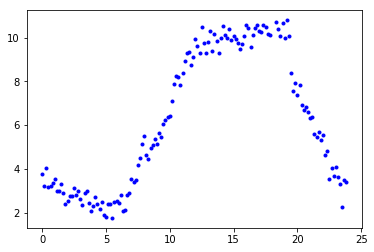

In [142]:
fix = np.zeros(4464)
fix[index] = meteo['vent']
ndays = 31
mm = fix.reshape(ndays, 24*6)/ndays
plt.plot(times, np.sum(mm, axis=0), 'b.')